In [1]:
from utils import FilteredImageFolder, count_trainable_parameters, count_elements_per_class, show_images, train_model
from torchvision import transforms
from torchvision.models import vgg16, VGG16_Weights
from torchinfo import summary
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import random
import torch
import os

manualSeed = 999 
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"runnning on {device}")

Random Seed:  999
runnning on cpu


# Hyperparameters

In [2]:
batch_size = 32
learning_rate = 0.001
num_epochs = 3

# Datasets

In [3]:
data_dir = r"C:\Users\yaoko\Downloads\archive\fruits-360-original-size\fruits-360-original-size"
TRAIN = "train"
VAL = "val"
TEST = "test"
data_transforms = {
    TRAIN: transforms.Compose(
        [
            # transforms.Resize(
            #     [256], interpolation=transforms.InterpolationMode.BILINEAR
            # ),
            # transforms.CenterCrop([224]),
            # transforms.ToTensor(),
            # transforms.Normalize(
            #     mean=[0.48235, 0.45882, 0.40784],
            #     std=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098],
            # ),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]
    ),
    VAL: transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]
    ),
    TEST: transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]
    ),
}
classes_to_include = [
    "apple_6",
    "apple_braeburn_1",
    "apple_crimson_snow_1",
    "apple_golden_1",
    "apple_golden_2",
    "apple_golden_3",
    "apple_granny_smith_1"
]
image_datasets = {
    x: FilteredImageFolder(
        root=os.path.join(data_dir, x),
        classes_to_include=classes_to_include,
        transform=data_transforms[x],
    )
    for x in [TRAIN, VAL, TEST]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}
dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}
for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
class_names = image_datasets[TRAIN].classes
n_classes = len(class_names)

Loaded 2205 images under train
Loaded 1103 images under val
Loaded 1102 images under test


In [4]:
for x in [TRAIN, VAL, TEST]:
    print("=" * 50)
    print(x)
    class_counts = count_elements_per_class(image_datasets[x])
    for class_name, count in class_counts.items():
        print(f"\t{class_name} => : {count}")

train
	apple_6 => : 315
	apple_braeburn_1 => : 320
	apple_crimson_snow_1 => : 318
	apple_golden_1 => : 308
	apple_golden_2 => : 308
	apple_golden_3 => : 316
	apple_granny_smith_1 => : 320
val
	apple_6 => : 158
	apple_braeburn_1 => : 160
	apple_crimson_snow_1 => : 159
	apple_golden_1 => : 154
	apple_golden_2 => : 154
	apple_golden_3 => : 158
	apple_granny_smith_1 => : 160
test
	apple_6 => : 157
	apple_braeburn_1 => : 160
	apple_crimson_snow_1 => : 159
	apple_golden_1 => : 154
	apple_golden_2 => : 154
	apple_golden_3 => : 158
	apple_granny_smith_1 => : 160


100%|██████████| 30/30 [00:00<00:00, 95.77it/s] 


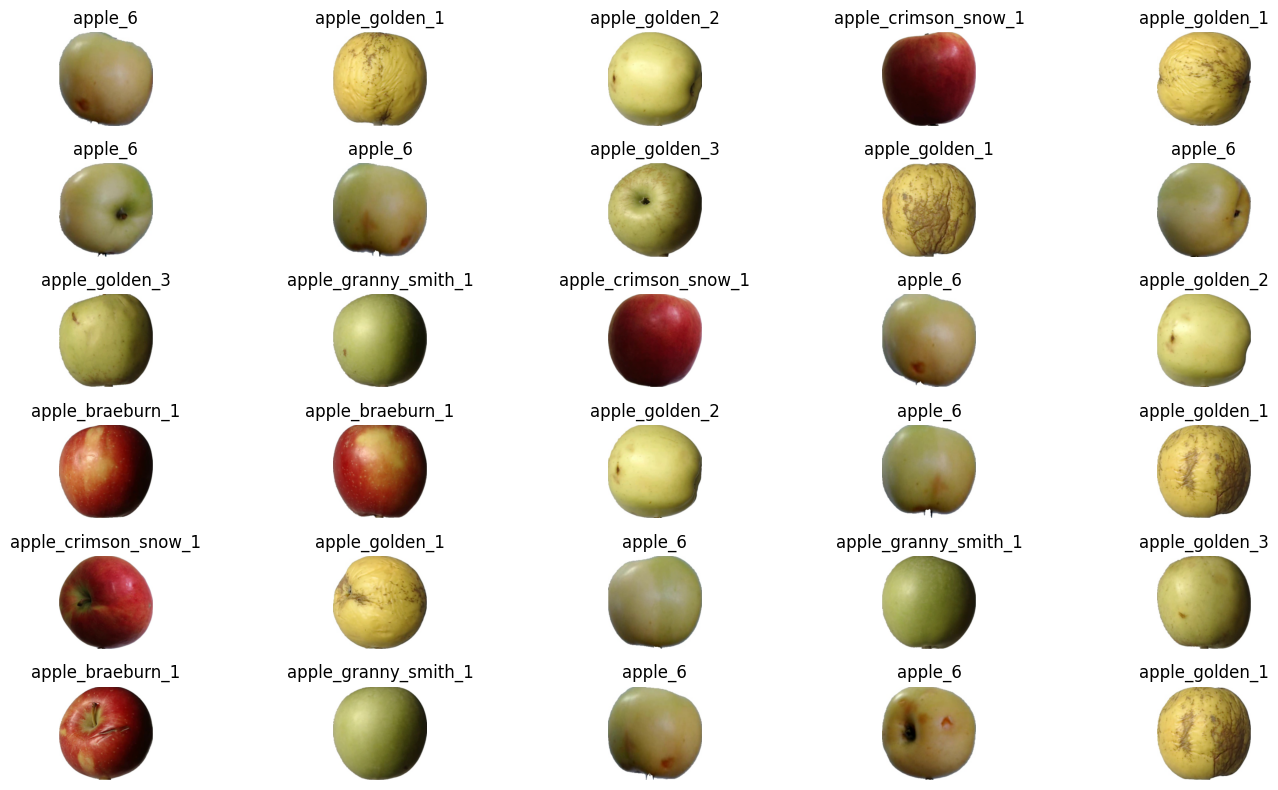

In [5]:
show_images(image_datasets[TRAIN], nb_rows=6, nb_cols=5, class_map=class_names)

# Model

In [6]:
input_size = (batch_size, 3, 224, 224)
model = vgg16(weights=VGG16_Weights.DEFAULT)
# summary(
#     model,
#     input_size=input_size,
#     col_names=["input_size", "output_size", "num_params", "trainable"],
#     col_width=20,
#     row_settings=["var_names"],
# )

In [7]:
n1 = count_trainable_parameters(model)
print("Number of trainable parameters", f"{n1:,d}")
# Freeze training for all layers
for param in model.parameters():
    param.require_grad = False
n_inputs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(n_inputs, n_classes)
model = model.to(device)
n2 = count_trainable_parameters(model)
print("Custom model number of trainable parameters", f"{n2:,d}")
print(f"{(n1-n2):,d}")
# summary(
#     model,
#     input_size=input_size,
#     col_names=["input_size", "output_size", "num_params", "trainable"],
#     col_width=20,
#     row_settings=["var_names"],
# )

Number of trainable parameters 138,357,544
Custom model number of trainable parameters 134,289,223
4,068,321


# Training

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=learning_rate)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = train_model(
    model=model,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    scheduler=exp_lr_scheduler,
    num_epochs=num_epochs,
)

Epoch 1/3
	Batch [6/69], loss: 1.7343
	Batch [12/69], loss: 1.4329
	Batch [18/69], loss: 1.2524
	Batch [24/69], loss: 1.1085
	Batch [30/69], loss: 0.9957
	Batch [36/69], loss: 0.9120
	Batch [42/69], loss: 0.8388
	Batch [48/69], loss: 0.7758
	Batch [54/69], loss: 0.7279
	Batch [60/69], loss: 0.6818
	Batch [66/69], loss: 0.6493
train Loss: 0.6333 Acc: 0.8009

Epoch 2/3


KeyboardInterrupt: 

# Test

In [ ]:
model.eval()
test_losses = []
correct = 0
total = 0
with torch.no_grad():
    for batch_data in tqdm(dataloaders[TEST]):
        images = batch_data[0].to(device)
        labels = batch_data[1].to(device)
        predictions = model(images)
        loss = criterion(predictions, labels)
        test_losses.append(loss.item())
        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
average_test_loss = np.mean(test_losses)
print(f"Average Test Loss: {average_test_loss:.4f}")
accuracy = 100 * correct / total
print(f"Accuracy on Test Data: {accuracy:.2f}%")

In [ ]:
test_loader = dataloaders[TEST]
batch_idx, (images, labels) = next(enumerate(test_loader))
dataset = image_datasets[TEST]
model.eval()
with torch.no_grad():
    output = model(images)  
    fig, axes = plt.subplots(5, 3, figsize=(15, 8))
    predictions = output.argmax(dim=1)  
    for i, ax in enumerate(axes.flat):    
        if i >= len(predictions) :
            break    
        ax.imshow(images[i].numpy().transpose((1, 2, 0)))
        prediction = predictions[i].item()
        target = labels[i].item()
        ax.axis("off")
        ax.set_title(f"pred={class_names[prediction]}, real={class_names[target]}", color='green' if prediction == target else 'red')
    plt.show()